# Data Cleaning, feature creating and modeling

### Uploading Packages

In [11]:
# importing packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
color = sns.color_palette()
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
%matplotlib inline
from pandas.io.json import build_table_schema
from pandas.plotting import scatter_matrix

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

### Importing datasets & converting to data frames

In [209]:
#train and test datasets
test = pd.read_csv("test_df.csv")
train = pd.read_csv("train_df.csv")
#macro dataset
macro1 = pd.read_csv("Macro_Test.csv")
macro2 = pd.read_csv("Macro_Train.csv")
#macro 3 is added as for adding extra macro features to the model
macro3 = pd.read_csv("macrodata.csv")
macro1 = pd.DataFrame(macro1)
macro2 = pd.DataFrame(macro2)
macro = pd.concat([macro2,macro1],axis = 0)

In [210]:
#Full Macro Data
macro_full = pd.read_csv("macro.csv", parse_dates=['timestamp'])

In [211]:
#adding new features - state and population
extra_features = pd.read_csv('housing_new_features.csv')

In [212]:
extra_features.head()

,id,ration_popul,state
0,1,155572,2
1,2,115352,2
2,3,101708,2
3,4,178473,2
4,5,108171,2


## Cleaning and Transforming the data 

### Housing data sets

In [213]:
#change the type of parameters
for f in train.columns:
    if train[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values)) 
        train[f] = lbl.transform(list(train[f].values))
        
for f in test.columns:
    if test[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(test[f].values)) 
        test[f] = lbl.transform(list(test[f].values))

(array([  7.08500000e+03,   3.52000000e+02,   1.20000000e+02,
          3.00000000e+00,   1.00000000e+00,   9.50000000e+01,
          4.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([  0.20925786,   5.76857608,  11.3278943 ,  16.88721252,
         22.44653074,  28.00584896,  33.56516718,  39.1244854 ,
         44.68380362,  50.24312184,  55.80244006]),
 <a list of 10 Patch objects>)

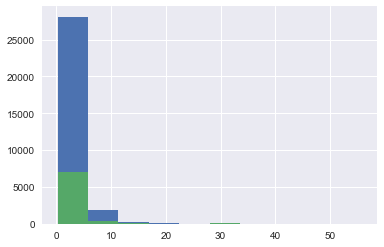

In [214]:
# create a distance column - agg of all distance features
train['dis']= (train['kindergarten_km'] + train['school_km'] + train['metro_km_avto'] + train['public_healthcare_km'])/4
test['dis']= (test['kindergarten_km'] + test['school_km'] + test['metro_km_avto'] + test['public_healthcare_km'])/4
plt.hist(train['dis'])
plt.hist(test['dis'])

In [215]:
train.loc[train['build_year'] == 20052009, 'build_year'] = 2009
train.loc[train['build_year'] == 4965, 'build_year'] = 1965
train.loc[train['build_year'] == 71, 'build_year'] = 1971
train.loc[train['build_year'] < 1800, 'build_year'] = np.nan

# Add state feature to the model

In [216]:
#removing features to avoid overfitting
del train['kindergarten_km']
del train['school_km']
del train['metro_km_avto']
del train['public_healthcare_km']
#del train['max_floor']


del test['kindergarten_km']
del test['school_km']
del test['metro_km_avto']
del test['public_healthcare_km']
#del test['max_floor']

print train.columns
test.columns

Index([u'id', u'month', u'year', u'sub_area', u'full_sq', u'build_year',
       u'floor', u'max_floor', u'price_doc', u'product_type', u'dis'],
      dtype='object')


Index([u'id', u'month', u'year', u'sub_area', u'full_sq', u'build_year',
       u'floor', u'max_floor', u'product_type', u'dis'],
      dtype='object')

In [217]:
# imputing year and month for full macro data frame
macro_full['year'] = pd.DatetimeIndex(macro_full['timestamp']).year
macro_full['month'] = pd.DatetimeIndex(macro_full['timestamp']).month

In [218]:
macro_full.to_csv("~/Desktop/macro_full.csv", index = False)

### Macro data sets

In [219]:
# macro data cleaning
print macro.shape
#create month and year columns from the timestamp
macro['year'] = pd.DatetimeIndex(macro['timestamp']).year
macro['month'] = pd.DatetimeIndex(macro['timestamp']).month
# in order to get a monthly trend in macroeconomics 
#creating monthly average usd value column for 
macro["m_a_usd"] = np.nan
macro["cpi_m"] = np.nan
macro['oil_urals_m'] = np.nan
macro['income_per_cap_'] = np.nan
macro['brent_'] = np.nan

macro.columns

(38133, 24)


Index([u'Unnamed: 0', u'balance_trade', u'brent', u'cpi', u'deposits_growth',
       u'eurrub', u'gdp_quart', u'gdp_quart_growth', u'id', u'income_per_cap',
       u'micex', u'micex_cbi_tr', u'micex_rgbi_tr', u'net_capital_export',
       u'oil_urals', u'ppi', u'price_doc', u'rent_price_1room_bus',
       u'rent_price_2room_bus', u'rent_price_3room_bus',
       u'rent_price_4+room_bus', u'rts', u'timestamp', u'usdrub', u'year',
       u'month', u'm_a_usd', u'cpi_m', u'oil_urals_m', u'income_per_cap_',
       u'brent_'],
      dtype='object')

In [220]:
#code for the extra macro features

# macro_full["mortgage_growth_"] = np.nan
# macro_full["pop_total_inc_"] = np.nan

#adding macro information
# mortgage growth - percetage of total value
#macro_full["mortgage_growth_"].fillna(macro_full.groupby(["year",'month'])["mortgage_growth"].transform("mean"), inplace=True)
# add population total increace column
#macro_full["pop_total_inc_"].fillna(macro_full.groupby(["year",'month'])["pop_total_inc"].transform("mean"), inplace=True)



In [221]:
#insert values to the new columns

#create average values by month and year for the usdrub / cpi / oil_urals
macro["m_a_usd"].fillna(macro.groupby(["year",'month'])["usdrub"].transform("mean"), inplace=True)
#monthly average of inplation
macro["cpi_m"].fillna(macro.groupby(["year",'month'])["cpi"].transform("mean"), inplace=True)
# Crude Oil Urals ($/bbl
macro["oil_urals_m"].fillna(macro.groupby(["year",'month'])["oil_urals"].transform("mean"), inplace=True)
#income per cap 
macro["income_per_cap_"].fillna(macro.groupby(["year",'month'])["income_per_cap"].transform("mean"), inplace=True)

### creating a new macro dataset for features that will be used for the prediction model

In [222]:
#create a data frame for the macro features generated from the macro data frame 
macro_test = pd.DataFrame()
macro_test['year'] = macro["year"]
macro_test["month"] = macro["month"]
macro_test["cpi"] = macro["cpi_m"]
macro_test["usd"] = macro["m_a_usd"]
macro_test["oil_urals"] = macro["oil_urals_m"]
macro_test["income_per_cap"] = macro["income_per_cap_"]
# macro_test["brent"] = macro["brent_"]
# extracting only the unique values of
macro_test = pd.DataFrame(macro_test.drop_duplicates())
macro_test.head()

,year,month,cpi,usd,oil_urals,income_per_cap
0,2011,8,354.0,28.921833,109.31,42688.6
3,2011,9,353.2,31.414226,111.29,40311.3
42,2011,10,353.0,31.137589,108.24,44388.0
255,2011,11,354.7,30.874150,110.43,46476.2
514,2011,12,356.2,31.582145,107.90,82685.3


In [223]:
#merging the macro test & macro 3 (with mortgage growth info) to create a final macro dataset
macro_final = pd.merge(macro3, macro_test,  how='left', left_on=['year','month'], right_on = ['year','month'])

In [224]:
macro_final.head(10)

,year,month,mortgage_growth,pop_total_inc,cpi,usd,oil_urals,income_per_cap
0,2011,1,1.550459,6.2,NaN,NaN,NaN,NaN
1,2011,2,1.482660,6.2,NaN,NaN,NaN,NaN
2,2011,3,1.344303,6.2,NaN,NaN,NaN,NaN
3,2011,4,1.207677,6.2,NaN,NaN,NaN,NaN
4,2011,5,1.109417,6.2,NaN,NaN,NaN,NaN
5,2011,6,1.107151,6.2,NaN,NaN,NaN,NaN
6,2011,7,1.107260,6.2,NaN,NaN,NaN,NaN
7,2011,8,1.051914,6.2,354.0,28.921833,109.31,42688.6
8,2011,9,1.049543,6.2,353.2,31.414226,111.29,40311.3
9,2011,10,1.030292,6.2,353.0,31.137589,108.24,44388.0


In [225]:
del macro_final['pop_total_inc']

### Creating the train and test final data sets

In [226]:
#create train + macro data set
#train_final = pd.merge(train, macro_test, how='left', on = ['year','month'])
train_final = pd.merge(train, macro_final,  how='left', left_on=['year','month'], right_on = ['year','month'])
#create test + macro data set
test_final = pd.merge(test, macro_final, how='left', on = ['year','month'])

In [227]:
train_final.head()

,id,month,year,sub_area,full_sq,build_year,floor,max_floor,price_doc,product_type,dis,mortgage_growth,cpi,usd,oil_urals,income_per_cap
0,1,8,2011,1,43.0,1974.0,4.0,7.667123,5850000,0,0.607419,1.051914,354.0,28.921833,109.31,42688.6
1,2,8,2011,23,34.0,2017.0,3.0,7.667123,6000000,0,0.636540,1.051914,354.0,28.921833,109.31,42688.6
2,3,8,2011,43,43.0,1969.0,2.0,7.667123,5700000,0,0.485578,1.051914,354.0,28.921833,109.31,42688.6
3,4,9,2011,21,89.0,2015.0,9.0,9.000000,13100000,0,0.891042,1.049543,353.2,31.414226,111.29,40311.3
4,5,9,2011,49,77.0,2014.0,4.0,7.667123,16331452,0,0.655766,1.049543,353.2,31.414226,111.29,40311.3


In [228]:
#adding state and population to the final datasets
train_final = pd.merge(train_final, extra_features , on='id')

In [229]:
#adding state and population to the final datasets
test_final = pd.merge(test_final, extra_features , on='id')

In [230]:
#create data sets without id for the actull model
train_no_id= train_final
test_no_id= test_final
del train_no_id['id']
del test_no_id['id']

### Preparing the data for submission to Kaggle

In [231]:
#testing the new data frames - agg distance & new features from macro data set
X_train = train_no_id.drop('price_doc',axis=1)
Y_train = train_no_id['price_doc']
#using the log of the price_doc for the training
log_Y = np.log(Y_train + 1)
T_train_xgb = xgb.DMatrix(X_train, log_Y)

### Cross Validation for XGBOOST parameters 

In [ ]:
xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model,
                   {'learning_rate': [0.01],
                    'max_depth': [9],
                    'n_estimators': [1800], 'colsample_bytree':[0.4]}, verbose=1)
clf.fit(X_train, Y_train)

In [250]:
params = {"booster":"gbtree",
          "eta": 0.01,
          "n_estimators": 1800,
          "max_depth": 9,
          "subsample": 1,
          "colsample_bytree": 0.4,
          "objective": 'reg:linear',
          "eval_metric": 'rmse',
          "silent": 0}

In [251]:
grid_search = xgb.cv(params, T_train_xgb, num_boost_round=5000, nfold=3,
        verbose_eval=50, early_stopping_rounds = 50)

[0]	train-rmse:14.9706+0.00203352	test-rmse:14.9706+0.00413391
[50]	train-rmse:9.06878+0.000907557	test-rmse:9.069+0.00410798
[100]	train-rmse:5.50378+0.000254444	test-rmse:5.50406+0.00383502
[150]	train-rmse:3.35571+0.00078267	test-rmse:3.3562+0.00328059
[200]	train-rmse:2.06902+0.00109101	test-rmse:2.07023+0.00254506
[250]	train-rmse:1.30866+0.00169062	test-rmse:1.31274+0.00224592
[300]	train-rmse:0.870853+0.00249563	test-rmse:0.882621+0.00299946
[350]	train-rmse:0.631475+0.00293619	test-rmse:0.654954+0.00491193
[400]	train-rmse:0.508682+0.00305048	test-rmse:0.545602+0.00673395
[450]	train-rmse:0.448057+0.003241	test-rmse:0.497666+0.00791682
[500]	train-rmse:0.41713+0.00264107	test-rmse:0.477771+0.00865735
[550]	train-rmse:0.39849+0.0028585	test-rmse:0.469402+0.00901862
[600]	train-rmse:0.38658+0.00216847	test-rmse:0.465865+0.00911534
[650]	train-rmse:0.376974+0.00156096	test-rmse:0.464304+0.00918495
[700]	train-rmse:0.369528+0.00127289	test-rmse:0.46358+0.00913406
[750]	train-rmse:0

In [249]:
# testing the result of the CV
print clf.best_params_
print clf.best_score_

{'n_estimators': 1800, 'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 9}
0.600070858328


### Training the XGBOOST using the parameters from the CV 

In [252]:
params = {"booster":"gbtree",
          "eta": 0.01,
          "n_estimators": 1800,
          "max_depth": 9,
          "subsample": 1,
          "colsample_bytree": 0.4,
          "objective": 'reg:linear',
          "eval_metric": 'rmse',
          "silent": 0}

gbm = xgb.train(dtrain = T_train_xgb, params = params, num_boost_round=850)

In [253]:
# checking the importance of each of the features
gbm.get_score()

{'build_year': 17418,
 'cpi': 7214,
 'dis': 19604,
 'floor': 9929,
 'full_sq': 18228,
 'income_per_cap': 6933,
 'max_floor': 10163,
 'month': 8316,
 'mortgage_growth': 10059,
 'oil_urals': 7151,
 'product_type': 2123,
 'ration_popul': 15370,
 'state': 3616,
 'sub_area': 12169,
 'usd': 7820,
 'year': 3923}

In [254]:
#predict the price for the test data set using the train model
Y_pred = gbm.predict(xgb.DMatrix(test_no_id))

In [255]:
# convert the log of the predicted price
Y_pred = np.expm1(Y_pred)

### Preparing the predicted price for submission 

In [256]:
submission = pd.DataFrame()
submission['id'] = test["id"]
submission["price_doc"] = Y_pred
submission.head(10)

# making sure all the predicted values are positive
submission.loc[submission.price_doc < 0, ] 

,id,price_doc


In [ ]:
#changing the negative values to positive
submission.loc[submission.price_doc < 0, "price_doc"] *= -1

In [257]:
# creating a csv file for submission
submission.to_csv("~/Desktop/24Submission.csv", index = False)

# Macro Data Visualization  

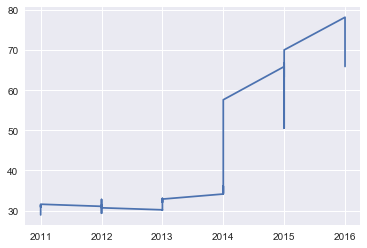

In [19]:
#CPI over time
plt.plot(macro_final['year'],macro_final['usd'])

In [1]:
scatter_matrix(macro_final)

NameError: name 'scatter_matrix' is not defined

In [23]:
def timeseries_plot(data, val, timestamp='timestamp', by='day'):
    by = by.strip().lower()
    if by == 'day':
        data.loc[:, [timestamp, val]].groupby(timestamp).agg('mean').plot()
        return
    elif by == 'weekday':
        by = '%w'
    elif by == 'month':
        by = '%m'
    elif by == 'year-month':
        by = '%Y-%m'
    elif by == 'year':
        by = '%Y'
    by_what = data[timestamp].apply(lambda x: x.strftime(by))
    data.loc[:, [timestamp, val]].groupby(by_what).agg('mean').plot()

AttributeError: 'str' object has no attribute 'strftime'

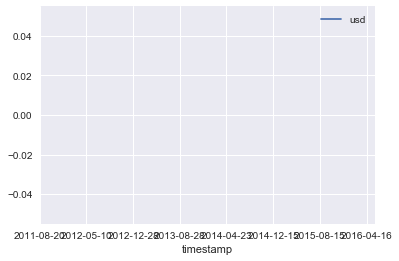

In [24]:
timeseries_plot(macro, val='usd', by='day')    
timeseries_plot(macro, val='usd', by='weekday')    
timeseries_plot(macro, val='usd', by='month')    
timeseries_plot(macro, val='usd', by='year')
timeseries_plot(macro, val='usd', by='%Y-%m')

In [25]:
def corr_plot(data):
    corrmtx = data.corr()
    sns.clustermap(corrmtx, annot=True, linewidths=.5)

In [ ]:
corr_plot(train_no_id)
corr_plot(test_no_id)

/Users/chentrilnik/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/chentrilnik/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/chentrilnik/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:
